# Model Result Comparison -- Bar Plots and Precision-Recall Curve

## Outline

The **MLAging - all-cell** workflow consists of sections:

`00 preprocessing.R` Data preprocessing and preparation in Seurat.

`111 All-cell Model Tuning - Before Binarization` ML model tunning using *non-binarized* HVGs and hyperparameter selection using `GridSearchCV`.

`112 All-cell Model Tuning - After Binarization` ML model tunning using *binarized* HVGs.

`121 All-cell Model 10x - Before Binarization` Run the best models for non-binarized* HVGs over 10 random seeds.

`122 All-cell Model 10x - After Binarization` Run the best models for *binarized* HVGs over 10 random seeds.
 
`123 All-cell Model 10x Swapped Train-Test` Run the best models for *binarized* HVGs over 10 random seeds. But switched the training and test sets to make sure that the sequencing throughput did not affect model performance.

`13 All-cell Model Result Viz` Result visulization -- **this notebook**:
1. [Performance (AUPRC) bar plots](#1.-barplot)
2. [Precision-Recall curve](#2.-prcurve)

`14 All-cell ELN Interpretation` Result interpretation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from statistics import mean, stdev
from sklearn.utils import shuffle
from sklearn.metrics import precision_recall_curve, auc, make_scorer
from src.data_processing import *
from src.grid_search import *

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

import warnings
warnings.filterwarnings('ignore')

In [2]:
pr_auc_scorer = make_scorer(pr_auc_score, greater_is_better=True,
                            needs_proba=True)

## 1. Performance (AUPRC) bar plots <a name="1.-barplot"></a>

In [3]:
models_n = ['l1_n', 'l2_n', 'eln_n', 'rfc_n', 'xgbc_n', 'svc_n', 'mlp_n']
for i in models_n:
    model_name = i[:-2]
    file = open('../results/results_nonbin_best/' + model_name + '_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [4]:
models = ['l1', 'l2', 'eln', 'rfc',  'xgbc', 'svc', 'mlp'] 
for i in models:
    file = open('../results/results_bin_best/' + i + '_model_test_scores.save', 'rb')
    locals()[i]  = pickle.load(file)
    file.close()

In [5]:
df_bar = pd.DataFrame(columns=['model', 'binarization', 'AUPRC'])

for i in models_n:
    df_new = pd.DataFrame(columns=['model', 'binarization', 'AUPRC'], index=range(0, 10))
    df_new['model'] = i[:-2]
    df_new['binarization'] = 'before'
    df_new['AUPRC'] = locals()[i]
    df_bar = df_bar.append(df_new)

In [6]:
for i in models:
    df_new = pd.DataFrame(columns=['model', 'binarization', 'AUPRC'], index=range(0, 10))
    df_new['model'] = i
    df_new['binarization'] = 'after'
    df_new['AUPRC'] = locals()[i]
    df_bar = df_bar.append(df_new)

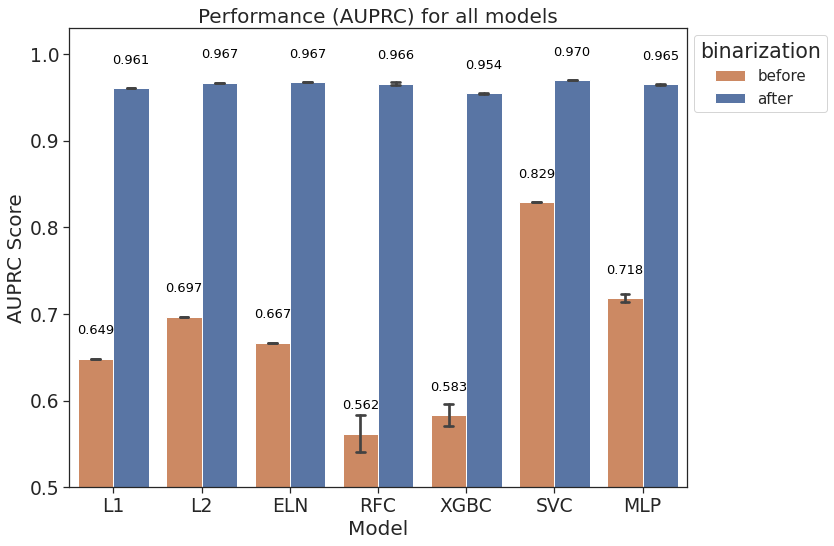

In [7]:
sns.color_palette()
plt.figure(figsize=(12,8))
sns.set(font_scale=1.7, style='ticks')
df_bar.model = df_bar.model.str.upper()

ax = sns.barplot(data=df_bar, x='model', y='AUPRC', hue='binarization', ci='sd', capsize=.1, 
                 palette=[sns.color_palette()[1], sns.color_palette()[0]])

for p in ax.patches:
    ax.text(p.get_x() + p.get_width()/2., p.get_height()+0.025, '{0:.3f}'.format(p.get_height()), 
        fontsize=13, color='black', ha='center', va='bottom')

plt.title('Performance (AUPRC) for all models', fontsize=20)
plt.xlabel("Model", fontsize=20)
plt.ylabel("AUPRC Score", fontsize=20)
plt.ylim(0.5, 1.03)
plt.legend(title='binarization', bbox_to_anchor=(1, 1), fontsize=15)
plt.tight_layout()
#plt.savefig('../figures/2b_models_bar_AUPRC.pdf')
plt.show()

## 2. Precision-Recall Curve <a name="2.-prcurve"></a>

In [8]:
file = open('../results/results_bin_best/l1_model_test_sets.save', 'rb')
test_set =  pickle.load(file)
file.close()

file = open('../results/results_nonbin_best/l1_model_test_sets.save', 'rb')
test_set_n =  pickle.load(file)
file.close()

In [9]:
test_X, test_y = test_set[0]

In [10]:
test_X_n, test_y_n = test_set_n[0]

In [11]:
models_n = ['l1_n', 'l2_n', 'eln_n', 'rfc_n', 'xgbc_n', 'svc_n'] 
for i in models_n:
    model_name = i[:-2]
    file = open('../results/results_nonbin_best/' + model_name + '_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    locals()[i]  = all_10_files[0]
    file.close()

In [12]:
models = ['l1', 'l2', 'eln', 'rfc',  'xgbc', 'svc'] 
for i in models:
    file = open('../results/results_bin_best/' + i + '_model_test_models.save', 'rb')
    all_10_files = pickle.load(file)
    locals()[i]  = all_10_files[0]
    file.close()

In [13]:
# MLP models were generated using the MLP pipeline and the corresponding virtual environment
file = open('../results/results_nonbin_best/mlp_pr.save', 'rb')
recall_mlp_n, precision_mlp_n, auprc_mlp_n  = pickle.load(file)
file.close()

file = open('../results/results_bin_best/mlp_pr.save', 'rb')
recall_mlp, precision_mlp, auprc_mlp  = pickle.load(file)
file.close()

In [14]:
# for ML models
def calculate_MLPR(ML_model, test_X, test_y):
    y_test_prob = ML_model.predict_proba(test_X)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_y, y_test_prob)
    return recall, precision, auc(recall, precision)

In [15]:
# SVC prediction takes a long time, so ran and stored it ahead of time (during the model testing)
file = open('../results/results_nonbin_best/svc_pr.save', 'rb')
recall_svc_n, precision_svc_n, auprc_svc_n = pickle.load(file)
file.close()

file = open('../results/results_bin_best/svc_pr.save', 'rb')
recall_svc, precision_svc, auprc_svc = pickle.load(file)
file.close()

In [16]:
# calculate the baseline, the major category is aged
a = l1.predict_proba(test_X)[:,1]
a = a *0 + 1
precision, recall, thresholds = precision_recall_curve(test_y, a)
baseline =  auc(recall, precision)
baseline

0.8286780851998243

In [17]:
blues = sns.color_palette("Blues", 7)

In [18]:
oranges = sns.color_palette("Oranges", 7)

In [19]:
models.append('mlp')
models_n.append('mlp_n')

In [20]:
models

['l1', 'l2', 'eln', 'rfc', 'xgbc', 'svc', 'mlp']

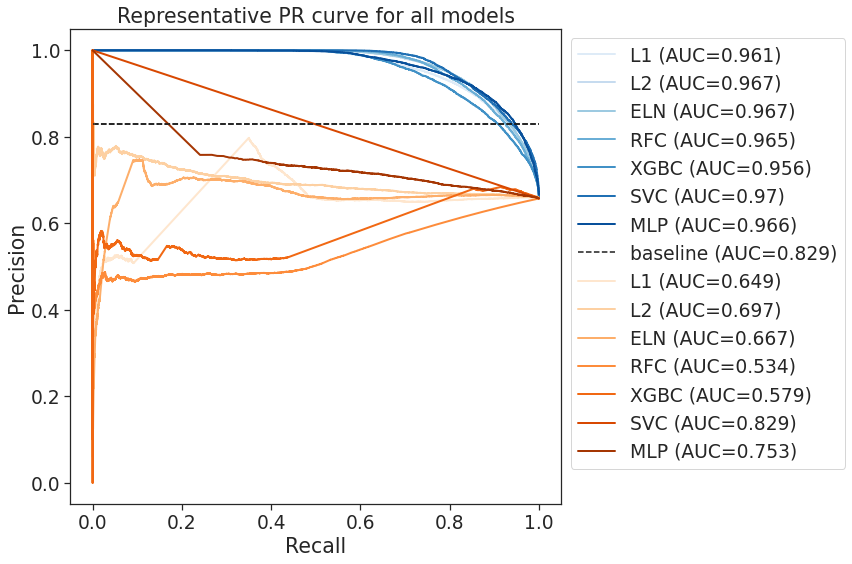

In [21]:
plt.figure(figsize=(12,8))
sns.set(font_scale=1.7, style='ticks')

for i in models:
    if i == 'mlp':
        plt.plot(recall_mlp, precision_mlp, 'b', 
                 label=f'{i.upper()} (AUC={round(auprc_mlp, 3)})',
                 color=blues[-1], lw=2)
    else:
        if i == 'svc':
            plt.plot(recall_svc, precision_svc, 'b', 
            label=f'{i.upper()} (AUC={round(auprc_svc, 3)})',
            color=blues[-2], lw=2)
        else:
            recall, precision, auprc = calculate_MLPR(locals()[i], test_X, test_y)
            plt.plot(recall, precision, 'b', 
                 label=f'{i.upper()} (AUC={round(auprc, 3)})',
                 color=blues[models.index(i)], lw=2)

plt.plot([0, 1], [baseline, baseline], 'k--' , label=f'baseline (AUC={round(baseline, 3)})')
            
for i in models_n:
    name = i.split('_')[0]
    if i == 'mlp_n':
        plt.plot(recall_mlp_n, precision_mlp_n, 'b', 
                 label=f'{name.upper()} (AUC={round(auprc_mlp_n, 3)})',
                 color=oranges[-1], lw=2)
    else:
        if i == 'svc_n':
            plt.plot(recall_svc_n, precision_svc_n, 'b', 
                 label=f'{name.upper()} (AUC={round(auprc_svc_n, 3)})',
                 color=oranges[-2],lw=2)
        else:
            recall, precision, auprc = calculate_MLPR(locals()[i], test_X_n, test_y_n)
            plt.plot(recall, precision, 'b', 
                 label=f'{name.upper()} (AUC={round(auprc, 3)})',
                 color=oranges[models_n.index(i)],lw=2)

plt.plot([0, 1], [baseline, baseline], 'k--' )
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.rcParams.update({'font.size': 12})   
plt.title('Representative PR curve for all models')
    
plt.legend(bbox_to_anchor=(1, 1))
plt.tight_layout()
# plt.savefig('../figures/2c_pr_curve_2.pdf')